In [1]:
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Label

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO
import torch
import cv2
import PIL.Image as Image

import os
import shutil
import pathlib
import sys
import yaml

In [2]:
# go to parent directory
os.chdir("../..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs/detection"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
dataset_yaml = ROOT_DIR / "dataset.yaml"
SLIDES_PATH = ROOT_DIR / "slides"

# set path to repo_dir
os.chdir(REPO_DIR)

## Dataset


### Dataset & Model Constants

In [3]:
RANDOM_SEED = 42
IMAGE_SIZE = 640

BATCH_SIZE = 2          # Platform Dependent; 
                            # 32-64 for rtX 5000 series
                            # 1-4 for mac m1

yaml_file_path = ROOT_DIR / "dataset.yaml"
with open(yaml_file_path, "r") as f:
    dataset_details = yaml.safe_load(f)

NUM_CLASSES = len(dataset_details["names"])
CLASS_NAMES = dataset_details["names"]

In [4]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Dataset Explore

In [5]:
dataset_df = pd.read_csv(DATA_BASE_PATH / "dogs_df.csv")
dataset_df.head()

,breed,image_path,annotation_path,new_annotation_path
0,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
2,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
3,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
4,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...


In [6]:
def render_results(
    image,
    boxes: list[float],
    classes: list[int],
    give_labels: bool = True,
):
    """
    Render bounding boxes and labels on an image.

    Args:
        image: Single image as an input.
        boxes: List of bounding boxes; each box is represented as [x, y, w, h].
        classes: List of class labels; each label is an integer.
        give_labels: Flag to indicate whether to display labels or not.

    Returns:
        Rendered image with bounding boxes and labels (if specified).
    """
    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i % 20)[:-1] for i in range(NUM_CLASSES)]) * 255

    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image.shape

    for box, cls in zip(boxes, classes):
        x, y, w, h = [coord * image_dim for coord in box]
        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)
        
        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 2)
        cls_name = CLASS_NAMES[int(cls)]

        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_position = (x1 + 1, y2 + text_size[1] + 4)
            
            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 + text_size[1] + 4),
                b_col,
                -1
            )
            
            image_cv = cv2.putText(
                image_cv,
                cls_name,
                text_position,
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 255, 255),
                2,
                cv2.LINE_AA,
                False
            )

    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    return image


In [7]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

def render_results(
    image, 
    boxes: list[float], 
    classes: list[int],
    give_labels: bool = True,
):
    # image - single image
    # boxes - list of boxes; box = [x, y, w, h]
    # labels - list of labels; label = int
    
    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i%20)[:-1] for i in range(NUM_CLASSES)]) * 255
    
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image_cv.shape
    
    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        x, y, w, h = (
            x * image_w,
            y * image_h,
            w * image_w,
            h * image_h
        )
        
        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)
        
        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 2)
        cls_name = CLASS_NAMES[int(cls)]
        
        # add text
        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_position = (x1 + 1, y2 - 2)
            
            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 - text_size[1] - 4),
                b_col,
                -1,  # filled rectangle
            )
            image_cv = cv2.putText(
                image_cv, 
                cls_name, 
                text_position, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, 
                (255, 255, 255), 
                2,
                cv2.LINE_AA,
                False,
            )
        
    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        
    return image


In [17]:
slide_vars = {}

def image_slider(images, slide_name=None, num_images=8):
    slide_name = slide_name or np.random.randint(0, 100000)
    if num_images > len(images) or num_images == -1:
        num_images = len(images)

    def save_as_slides(slide_name, images):
        save_path = SLIDES_PATH / f"slide_{slide_name}"

        os.makedirs(save_path, exist_ok=True)
        try:
            shutil.rmtree(save_path)
            os.makedirs(save_path)
            for image in images:
                image = Image.fromarray(image)
                image.save(save_path / f"{np.random.randint(0, 100000)}.jpg")
        except Exception as e:
            print(e)
            print("Error while saving images as slides")

    def load_slides(slide_num) -> list:
        slide_path = ROOT_DIR / f"slides/slide_{slide_num}"
        images = [str(slide_path / image) for image in os.listdir(slide_path) if image.endswith(".jpg")]
        return str(slide_path), images

    save_as_slides(slide_name, images[:num_images])
    _, images = load_slides(slide_name)

    global slide_vars
    slide_vars[slide_name] = {"image_index": 0}
    current_slide = slide_vars[slide_name]

    # Show image
    def show_image():
        clear_output(wait=True)
        display(HBox([current_slide["previous_button"], current_slide["next_button"]]))
        image_path = images[current_slide["image_index"]]
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def update_label():
        index_label.value = f"Image Index: {current_slide['image_index'] + 1}/{num_images}"

    def button_click(step):
        current_slide = slide_vars[slide_name]

        idx = current_slide["image_index"] + step
        idx = idx % num_images
        current_slide["image_index"] = idx
        show_image()
        update_label()

    previous_button = Button(description='Previous', button_style='info', layout={'width': 'auto'})
    previous_button.on_click(lambda x: button_click(-1))
    current_slide["previous_button"] = previous_button

    next_button = Button(description='Next', button_style='info', layout={'width': 'auto'})
    next_button.on_click(lambda x: button_click(1))
    current_slide["next_button"] = next_button

    index_label = Label(value=f"Image Index: {current_slide['image_index'] + 1}/{num_images}")
    display(HBox([previous_button, next_button, index_label]))

    show_image()
    update_label()


In [12]:
data_sample = dataset_df.sample(8)

images, all_boxes, all_classes = [], [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    with open(annotation_path, "r") as f:
        data = f.readlines()
        
    for line in data:
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)
            
    all_boxes.append(boxes)
    all_classes.append(classes)

all_classes

[[7], [36], [3], [46], [7], [48], [39], [79]]

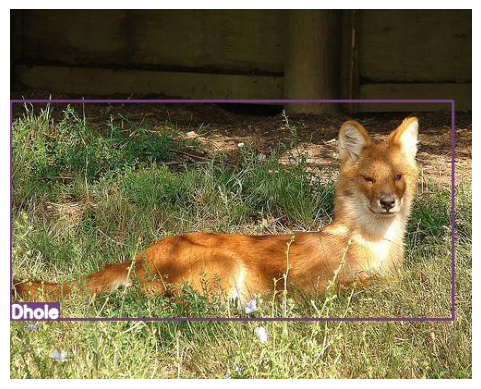

In [18]:
slide_name = 1

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name)

result_images = None

## Model

#### Basic inferance

In [76]:
model = YOLO("yolov5nu.pt")

In [95]:
results = model(image)


0: 480x640 1 cat, 1 dog, 1 vase, 139.6ms
Speed: 3.9ms preprocess, 139.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


In [97]:
classes

tensor([15., 16., 75.])

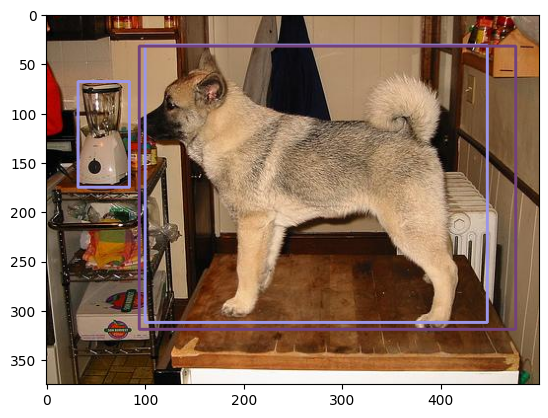

In [98]:
# image = results[0].orig_img
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
boxes = results[0].boxes.xywhn
classes = results[0].boxes.cls

result_image = render_results(image, boxes, classes, give_labels=False)
plt.imshow(result_image)